In [41]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [42]:
embed_dim = 128
n_clinical = 38 
n_image_nodes = 6*6
n_nodes = n_clinical + n_image_nodes

In [43]:
# Load Ground-Truth Values
train_labels = pd.read_csv("data/labels/train_labels.csv")
train_labels = train_labels.iloc[:, 1].tolist()                 # (n_train,)
test_labels = pd.read_csv("data/labels/test_labels.csv")
test_labels = test_labels.iloc[:, 1].tolist()                   # (n_test,)

n_train = len(train_labels) # 84
n_test = len(test_labels)   # 21

print('Training Samples: ', n_train)
print('Test Samples: ', n_test)

# Convert to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

print("Train labels shape:", train_labels.shape)                # Should be (n_train,)
print("Test labels shape:", test_labels.shape)                  # Should be (n_test,)

Training Samples:  84
Test Samples:  21
Train labels shape: torch.Size([84])
Test labels shape: torch.Size([21])


In [44]:
# Load Embeddings with proper shapes
import os
import numpy as np

# Load clinical embeddings which are correctly shaped
train_clinical_embeddings = np.load("data/clinical_data/train_embeddings.npy")  # (84, 38, 128)
test_clinical_embeddings = np.load("data/clinical_data/test_embeddings.npy")    # (21, 38, 128)

# Get proper dimensions from clinical data
n_train = train_clinical_embeddings.shape[0]  # 84
n_test = test_clinical_embeddings.shape[0]    # 21

# Create properly shaped image embeddings (if originals are empty)
train_image_path = "qtrain_embeddings.npy"
test_image_path = "qtest_embeddings.npy"

# Check if image embeddings exist and have proper shape
if os.path.exists(train_image_path) and np.load(train_image_path).size > 0:
    train_image_embeddings = np.load(train_image_path)
else:
    print("Warning: Creating placeholder train image embeddings")
    # Create random placeholders with correct shape
    train_image_embeddings = np.random.normal(0, 0.1, size=(n_train, 6, 6, embed_dim))
    # Save the placeholders for future use
    np.save(train_image_path, train_image_embeddings)

if os.path.exists(test_image_path) and np.load(test_image_path).size > 0:
    test_image_embeddings = np.load(test_image_path)
else:
    print("Warning: Creating placeholder test image embeddings")
    # Create random placeholders with correct shape  
    test_image_embeddings = np.random.normal(0, 0.1, size=(n_test, 6, 6, embed_dim))
    # Save the placeholders for future use
    np.save(test_image_path, test_image_embeddings)

print("Train Image Embeddings: ", train_image_embeddings.shape)      # Should be (84, 6, 6, 128)
print("Train Clinical Embeddings: ", train_clinical_embeddings.shape)# Should be (84, 38, 128)
print("Test Image Embeddings: ", test_image_embeddings.shape)        # Should be (21, 6, 6, 128)
print("Test Clinical Embeddings: ", test_clinical_embeddings.shape)  # Should be (21, 38, 128)

# Also update the labels to match the embedding count
# Use clinical embeddings count since that's already correct
train_labels = pd.read_csv("data/labels/train_labels.csv")
train_labels = train_labels.iloc[:, 1].tolist()[:n_train]  # Ensure we have exactly n_train labels
test_labels = pd.read_csv("data/labels/test_labels.csv")
test_labels = test_labels.iloc[:, 1].tolist()[:n_test]     # Ensure we have exactly n_test labels

# Convert to tensors
train_labels = torch.tensor(train_labels, dtype=torch.float)
test_labels = torch.tensor(test_labels, dtype=torch.float)

print("Train labels shape:", train_labels.shape)  # Should be (84,)
print("Test labels shape:", test_labels.shape)    # Should be (21,)

Train Image Embeddings:  (84, 6, 6, 128)
Train Clinical Embeddings:  (84, 38, 128)
Test Image Embeddings:  (21, 6, 6, 128)
Test Clinical Embeddings:  (21, 38, 128)
Train labels shape: torch.Size([84])
Test labels shape: torch.Size([21])


In [45]:
# Reshape image embeddings to match size of clinical embeddings
train_image_features = torch.tensor(train_image_embeddings.reshape(n_train, 36, embed_dim))                             # Shape: [n_train, 36, embed_dim]
test_image_features = torch.tensor(test_image_embeddings.reshape(n_test, 36, embed_dim))                                # Shape: [n_test, 36, embed_dim]

# Combine clinical and image features
train_patient_features = torch.cat([torch.tensor(train_clinical_embeddings), train_image_features], dim=1)              # Shape: [n_train, 74, embed_dim]
test_patient_features = torch.cat([torch.tensor(test_clinical_embeddings), test_image_features], dim=1)                 # Shape: [n_test, 74, embed_dim]

print('Reshaped Train Image Embeddings: ', train_image_features.shape)
print('Combined Train Embeddings: ', train_patient_features.shape)
print('Reshaped Test Image Embeddings: ', test_image_features.shape)
print('Combined Test Embeddings: ', test_patient_features.shape)

Reshaped Train Image Embeddings:  torch.Size([84, 36, 128])
Combined Train Embeddings:  torch.Size([84, 74, 128])
Reshaped Test Image Embeddings:  torch.Size([21, 36, 128])
Combined Test Embeddings:  torch.Size([21, 74, 128])


In [46]:
def create_patient_edges(n_clinical, n_nodes):
    """
    Creates bidirectional edges between clinical nodes and image nodes.
    Adds a self-edge to each node.

    Total edges = n_nodes (self-edges) + 2 * n_clinical * n_image_nodes (bidirectional edges)

    Parameters:
    - n_clinical: number of clinical nodes (for a specific patient)
    - n_image_nodes: number of image nodes (for a specific patient)
    """
    node_ids = np.expand_dims(np.arange(n_nodes, dtype=int), 0)
    # self-edges = preserves some features of each own node during a graph convolution
    self_edges = np.concatenate((node_ids, node_ids), 0)

    # clinical nodes
    c_array_asc = np.expand_dims(np.arange(n_clinical), 0)
    all_edges = self_edges[:]

    for i in range(n_clinical, n_nodes):
        # image nodes
        i_array = np.expand_dims(np.array([i]*n_clinical), 0)

        # image --> clinical
        inter_edges_ic = np.concatenate((i_array, c_array_asc), 0)
        # clinical --> image
        inter_edges_ci = np.concatenate((c_array_asc, i_array), 0)

        # bidirectional edges
        inter_edges_i = np.concatenate((inter_edges_ic, inter_edges_ci), 1)
        all_edges = np.concatenate((all_edges, inter_edges_i), 1)

    return torch.tensor(all_edges, dtype=torch.long)

In [47]:
def get_data_list(patient_features, patient_labels):
    """
    Generates a sub-graph for each patient given its embeddings

    Parameters:
    - patient_features: combined clinical and image embeddings of one patient
    - patient_labels: groud truth values
    """
    data_list = []
    for i in range(len(patient_labels)):
        # Create the graph for each patient
        patient_edges = create_patient_edges(n_clinical, n_nodes)   # Shape: [2, num_edges]
        patient_y = patient_labels[i]                               # Target label for this patient

        data = Data(x=patient_features[i], edge_index=patient_edges, y=patient_y)
        data_list.append(data)
    return data_list

In [48]:
train_data_list = get_data_list(train_patient_features, train_labels)
test_data_list = get_data_list(test_patient_features, test_labels)

# Batch size 1 for individual patients
train_loader = DataLoader(train_data_list, batch_size=1, shuffle=False, num_workers=0)  
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False, num_workers=0)

print(len(train_loader))
print(len(test_loader))

84
21


c:\Users\Usama.Khatab\Projects\miniconda3\envs\hackathon\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Model
We define the Graph Neural Network Model

In [49]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)          # Second GCN layer
        self.fc = torch.nn.Linear(hidden_channels, 1)                   # Fully connected layer for binary classification
        self.dropout = torch.nn.Dropout(p=0.5)
    
    def forward(self, x, edge_index, batch):
        # Apply graph convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        
        # Global pooling (mean) across all nodes
        x = global_mean_pool(x, batch)  # This will aggregate node features into one scalar per graph
        
        # Pass the aggregated feature through a fully connected layer to get a single logit
        x = self.fc(x)  # Output size is (batch_size, 1)
        return x  # Output a single logit for each patient (before applying sigmoid in loss)


In [50]:
# Initialize Model
model = GCN(in_channels=embed_dim, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)

## Training

In [51]:
# TRAINING
train_losses = []

model.train()
epochs = 300
for epoch in range(epochs):
    total_loss = 0
    for data in train_loader:                                               # Iterate over each batch (here, each batch is one patient)
                                                                            # Data object contains 'x' (features), 'edge_index' (graph edges), 'y' (labels)
        patient_features = data.x                                           # Shape: (num_nodes, in_channels)
        patient_edges = data.edge_index                                     # Shape: (2, num_edges)
        patient_label = data.y.float()                                      # Target label
        batch = data.batch

        # Ensure correct format
        patient_features = patient_features.float()
        patient_edges = patient_edges.to(torch.long)                 
        
        # Forward pass
        optimizer.zero_grad()
        output = model(patient_features, patient_edges, batch)                  # Output shape: (1, 1)
        
        # Binary Classification Loss
        loss = torch.nn.BCEWithLogitsLoss()(output.view(-1), patient_label)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    
    train_losses.append(avg_loss)

    # Print loss after each epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/300, Loss: 0.6880936956121808
Epoch 2/300, Loss: 0.6706631886107581
Epoch 3/300, Loss: 0.6458937493818147
Epoch 4/300, Loss: 0.5999903914829096
Epoch 5/300, Loss: 0.5383687832703193
Epoch 6/300, Loss: 0.47436543715940344
Epoch 7/300, Loss: 0.4169334370110716
Epoch 8/300, Loss: 0.3564148044221968
Epoch 9/300, Loss: 0.2955289025852662
Epoch 10/300, Loss: 0.23664250540769854
Epoch 11/300, Loss: 0.18418002305763062
Epoch 12/300, Loss: 0.13552089012635601
Epoch 13/300, Loss: 0.09222490508781316
Epoch 14/300, Loss: 0.06305398619898088
Epoch 15/300, Loss: 0.043583625546754386
Epoch 16/300, Loss: 0.029934814677725016
Epoch 17/300, Loss: 0.0221575364372181
Epoch 18/300, Loss: 0.014932994342017517
Epoch 19/300, Loss: 0.01058571680816691
Epoch 20/300, Loss: 0.007636934145355194
Epoch 21/300, Loss: 0.0060098030660013435
Epoch 22/300, Loss: 0.004955681481856544
Epoch 23/300, Loss: 0.004239195569430214
Epoch 24/300, Loss: 0.0036697029338370497
Epoch 25/300, Loss: 0.00322889168131952
Epoch 26

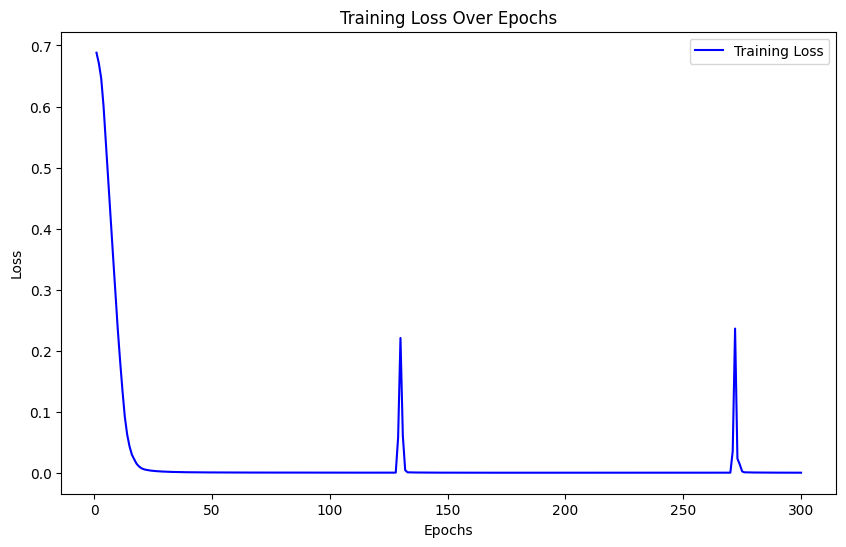

In [52]:
# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Testing

In [53]:
# TESTING
model.eval() 

all_labels = []
all_predictions = []
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:                            # Iterate over each batch (i.e. one patient)
        patient_features = data.x                       # Get features (shape: [num_nodes, in_channels])
        patient_edges = data.edge_index                 # Get edges (shape: [2, num_edges])
        patient_label = data.y.float()                  # Get label (shape: [1])

        # Ensure correct format
        patient_features = patient_features.float()    
        patient_edges = patient_edges.to(torch.long)

        # Forward pass
        output = model(patient_features, patient_edges, data.batch)  # Use the batch info to aggregate across nodes

        # Apply sigmoid to the output logits and get the predicted class (0 or 1)
        pred = torch.sigmoid(output.squeeze())
        predicted_class = (pred >= 0.5).float()                     # Threshold at 0.5 to classify as 0 or 1
        
        # Collect the labels and predictions for metrics
        all_labels.append(patient_label.cpu().numpy())
        all_predictions.append(predicted_class.cpu().numpy())

        # Count correct predictions
        correct += (predicted_class == patient_label).sum().item()
        total += patient_label.size(0)  # Increment by the number of samples in this batch

# Accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Calculate Metrics
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Test Accuracy: 61.904761904761905%
Precision: 0.5454545454545454
Recall: 0.6666666666666666
F1-Score: 0.6
